In [1]:
import pandas as pd
import pymssql
from datetime import datetime, date 

import numpy as np
from numpy import log
from prophet import Prophet

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from prophet.plot import add_changepoints_to_plot
import itertools

import holidays
import time

import random
from IPython.display import clear_output
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import pickle

/home/aaqil/aaqil_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
def get_data():
    try:
        con = pymssql.connect(user='username',password = 'password'
                 ,host='server',database='db',autocommit = True)
    except Exception as e:
        print('unable to connnect',e)
    cur=con.cursor()
    
    query="""
            SELECT CONVERT(DATE,CS.Process_Date) AS PROCESS_DATE,COUNT(DISTINCT CS.CLAIM_NO) CLAIM_COUNT
FROM CLAIMS_SUBMITTED AS CS
JOIN CLAIMS AS C ON C.Claim_No=CS.Claim_No
JOIN PATIENT AS P ON P.PATIENT_ACCOUNT=C.PATIENT_ACCOUNT
JOIN PRACTICES AS PR ON PR.PRACTICE_CODE=P.PRACTICE_CODE
AND PR.IS_ACTIVE=1 AND ISNULL(PR.IS_TEST_PRACTICE,0)=0
AND ISNULL(PR.EXCLUDE_FROM_BILLING_REPORTS,0) = 0
AND PR.EMR_NAME NOT IN ('CHARTS PRO','PM STANDALONE','TESTINGPRACTICE')
AND PR.PRACTICE_CODE NOT LIKE '9090%' AND PR.PRAC_NAME NOT LIKE '%TEST%'
WHERE ISNULL(CS.DELETED,0)=0 AND CONVERT(DATE,CS.Process_Date) BETWEEN '01-01-2020' AND '12-10-2022'
GROUP BY CONVERT(DATE,CS.Process_Date)
ORDER BY CONVERT(DATE,CS.Process_Date) ASC
            """
     
    try:
        cur.execute(query)
        df=pd.DataFrame(cur.fetchall(),columns=[x[0] for x in cur.description])
        cur.close
        con.close
        return df
    except Exception as e:
        print('error in query',e)
        con.close()

In [3]:
df=get_data()

In [4]:
data=df.copy
df.columns
df.shape

(1075, 2)

In [5]:
df.head()

,PROCESS_DATE,CLAIM_COUNT
0,2020-01-01,17099
1,2020-01-02,28627
2,2020-01-03,26803
3,2020-01-04,986
4,2020-01-05,7988


In [6]:
df['PROCESS_DATE']=pd.to_datetime(df['PROCESS_DATE'])

In [7]:
claim_data=df[['PROCESS_DATE','CLAIM_COUNT']]

In [8]:
claim_data.CLAIM_COUNT = claim_data.CLAIM_COUNT.apply(int)

In [9]:
# df[['CHARGE_SUM']].apply(int)

In [10]:
claim_data.head()

,PROCESS_DATE,CLAIM_COUNT
0,2020-01-01,17099
1,2020-01-02,28627
2,2020-01-03,26803
3,2020-01-04,986
4,2020-01-05,7988


In [11]:
claim_data = claim_data.rename(columns={'PROCESS_DATE': 'ds','CLAIM_COUNT': 'y'})

In [12]:
claim_data['ds'] = pd.DatetimeIndex(claim_data['ds'])

In [13]:
claim_data.set_index('ds',inplace=True)

In [14]:
train=claim_data.loc[:'09-30-2022']
test=claim_data.loc['10-01-2022':]

In [15]:
train.reset_index(inplace=True)
train.head(10)

,ds,y
0,2020-01-01,17099
1,2020-01-02,28627
2,2020-01-03,26803
3,2020-01-04,986
4,2020-01-05,7988
5,2020-01-06,23325
6,2020-01-07,17527
7,2020-01-08,14737
8,2020-01-09,19485
9,2020-01-10,15487


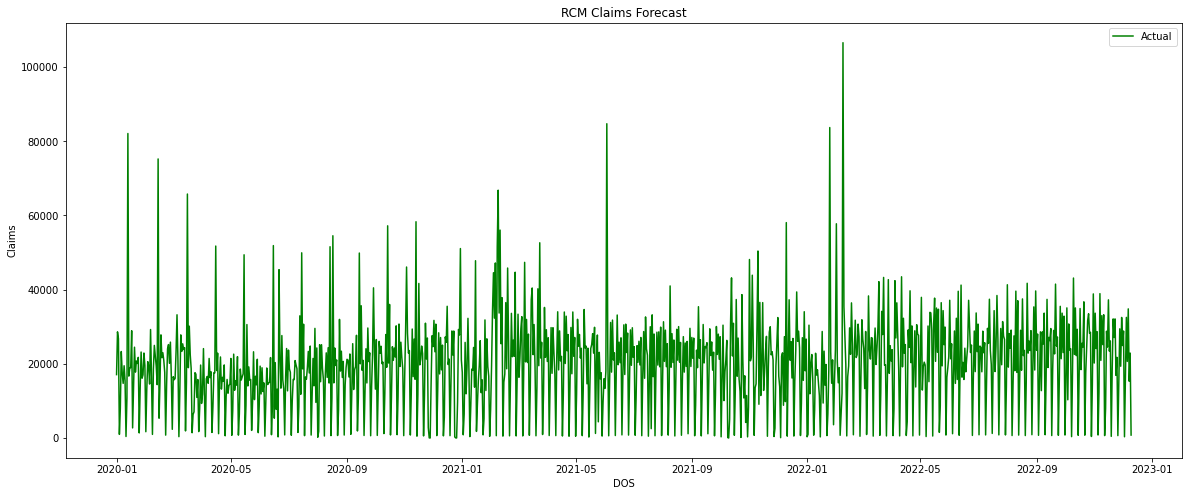

In [16]:
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(claim_data
         ,color='g', label='Actual')
plt.xlabel("DOS")
plt.ylabel("Claims")
plt.title("RCM Claims Forecast")
plt.legend(loc='upper right')
plt.show()

In [17]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2021,2022]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [18]:
test_fc=test.reset_index()
test_fc.head()

,ds,y
0,2022-10-01,809
1,2022-10-02,14866
2,2022-10-03,35087
3,2022-10-04,10311
4,2022-10-05,30750


In [19]:
train_fc=train.set_index('ds')#.loc['01-01-2020':]
train_fc=train_fc.reset_index()
train_fc.head()

,ds,y
0,2020-01-01,17099
1,2020-01-02,28627
2,2020-01-03,26803
3,2020-01-04,986
4,2020-01-05,7988


### Hyperparameter Tuning

In [20]:
my_model = Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,)

In [21]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[10,15,20],
              'n_changepoints' : [25,50,75,100,125]
              }
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [22]:
future_dates=pd.DataFrame(test_fc['ds'])
future_dates
model_parameters = pd.DataFrame(columns = ['mape','me','rmse','Parameters'])
cnt=1
for p in grid:
    clear_output(wait=True)
    print('Running at: ',cnt)
    cnt+=1
    test = pd.DataFrame()
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         holidays=holiday, 
#                          daily_seasonality=True,
#                          yearly_seasonality=True,
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.fit(train)
    train_forecast = train_model.predict(future_dates)
    fc=train_forecast[['ds','yhat']]
    me = me = np.mean(fc.yhat - test_fc.y)
    mape=np.mean(np.abs(fc.yhat - test_fc.y)/np.abs(test_fc.y)) 
    rmse=rmse = np.mean((fc.yhat - test_fc.y)**2)**.5
    model_parameters = model_parameters.append({'mape':mape,'me':me,'rmse':rmse,'Parameters':p},ignore_index=True)
    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


Running at:  150


INFO:cmdstanpy:finish chain 1


In [23]:
md=model_parameters.copy()
md['me']=abs(md['me'])
md.sort_values(by=['rmse'],ascending=True).iloc[0]['Parameters']


{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 10,
 'n_changepoints': 100,
 'seasonality_mode': 'multiplicative'}

In [24]:
#best rmse vale
{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 20,
 'n_changepoints': 100,
 'seasonality_mode': 'multiplicative'}

#best mape value
{'changepoint_prior_scale': 0.5,
 'holidays_prior_scale': 10,
 'n_changepoints': 50,
 'seasonality_mode': 'additive'}

my_model1 = Prophet(changepoint_prior_scale = 0.1,
                     holidays_prior_scale = 20,
                     n_changepoints = 100,
                     seasonality_mode = 'multiplicative',
                     weekly_seasonality=True,
#                      daily_seasonality=True,
#                      yearly_seasonality=True,
                     holidays=holiday,
                     interval_width=0.95)

In [25]:
my_model1.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [26]:
filename = 'RCM_Prophet_Overall_Submission_Claims.sav'
pickle.dump(my_model1, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))

date_range=pd.date_range(start = '09-01-2022', end = '12-10-2022')
future_dates=pd.DataFrame(date_range,columns=['ds'])


forecast_outsample = loaded_model.predict(future_dates)
forecast_outsample[['ds', 'yhat']].tail()

,ds,yhat
15,2022-09-16,29258.38983
16,2022-09-17,850.82888
17,2022-09-18,16303.48951
18,2022-09-19,34505.47514
19,2022-09-20,24028.35514


In [27]:
test=claim_data.loc['09-01-2022':'12-10-2022']

future_dates=pd.DataFrame(test.reset_index()['ds'])
future_dates

date_range=pd.date_range(start = '09-01-2022', end = '12-10-2022')
fd=pd.DataFrame(date_range,columns=['ds'])
test.tail()

,y
ds,
2022-10-16,16745
2022-10-17,34915
2022-10-18,18439
2022-10-19,25552
2022-10-20,24524


In [28]:
forecast_outsample = my_model1.predict(fd)
forecast_outsample[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(50)


,ds,yhat,yhat_lower,yhat_upper
0,2022-10-01,1032.63154,-15521.40488,17134.08280
1,2022-10-02,16539.48056,1530.63809,32515.98368
2,2022-10-03,34814.07894,19822.47212,50419.53695
3,2022-10-04,24188.23726,8905.29849,40250.82271
4,2022-10-05,32354.85713,15758.38765,49203.08419
5,2022-10-06,24721.12107,9337.63565,40959.55329
6,2022-10-07,29592.59785,14352.26050,45041.08463
7,2022-10-08,770.12972,-15978.42693,17292.58764
8,2022-10-09,16313.99902,811.93089,32261.08804
9,2022-10-10,28067.27086,11271.54530,44618.79364


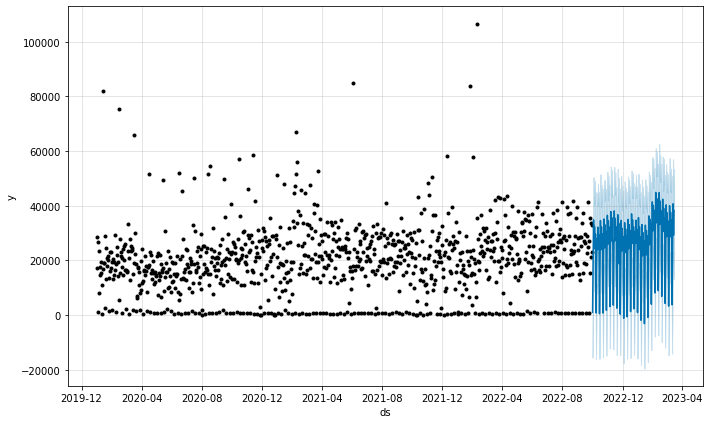

In [29]:
fig=my_model1.plot(forecast_outsample, uncertainty=True)

In [30]:
fc=forecast_outsample[['ds','yhat']]
fc.set_index('ds',inplace=True)
fc.head()

,yhat
ds,
2022-10-01,1032.63154
2022-10-02,16539.48056
2022-10-03,34814.07894
2022-10-04,24188.23726
2022-10-05,32354.85713


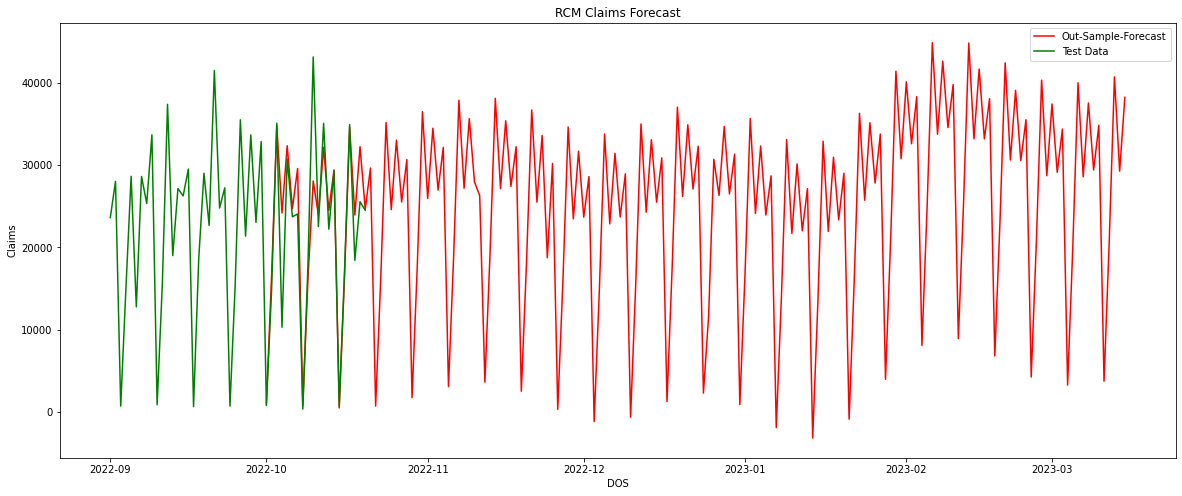

In [31]:
plt.rcParams["figure.figsize"] = (20,8)
#plt.plot(train.set_index('ds'),color='y', label='Train Data')
#plt.plot(tc,color='b', label='In-Sample-Forecast')
plt.plot(fc,color='r', label='Out-Sample-Forecast')
plt.plot(test,color='g', label='Test Data')
plt.xlabel("DOS")
plt.ylabel("Claims")
plt.title("RCM Claims Forecast")
plt.legend(loc='upper right')
plt.show()

In [32]:
# print('ME Out Sample Forecast: ',np.mean(fc.values-test.values))

# print('RMSE Out Sample Forecast: ',np.mean((fc.yhat - test.y)**2)**.5 )

# print('MAPE: ',np.mean(np.abs(fc.yhat - test.y)/np.abs(test.y)))

In [33]:
d=pd.merge(
    forecast_outsample[['ds', 'yhat']],
    test.reset_index(),
    how="left",
    on=['ds'],
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)
d['diff']=abs(d['yhat']-d['y'])
#d.to_csv('prophet.csv')
d.head(1000)

,ds,yhat,y,diff
0,2022-10-01,1032.63154,809.00000,223.63154
1,2022-10-02,16539.48056,14866.00000,1673.48056
2,2022-10-03,34814.07894,35087.00000,272.92106
3,2022-10-04,24188.23726,10311.00000,13877.23726
4,2022-10-05,32354.85713,30750.00000,1604.85713
...,...,...,...,...
161,2023-03-11,3749.52873,NaN,NaN
162,2023-03-12,20730.86515,NaN,NaN
163,2023-03-13,40715.86179,NaN,NaN
164,2023-03-14,29264.26647,NaN,NaN


In [34]:
predicted=d['yhat'].sum()
original=d['y'].sum()

print(predicted,original)


(original/predicted)*100
# (predicted/original)*100

4188471.671283585 431216.0


10.295306590144634

In [35]:
d.yhat = d.yhat.apply(int)

In [36]:
# def DUMP_DATA(d,forecast_section,pracice_code):
#     data_to_dump=d[['yhat','ds']]
#     data_to_dump['PRACTICE_CODE']=pracice_code
#     data_to_dump['FORECAST_TYPE']=forecast_section
#     data_to_dump.rename(columns={"yhat": "FORECASTED_VALUE", "ds": "FORECAST_DATE"},inplace=True)

#     con = pymssql.connect(user='mtbcweb',password = 'mtbcweb@mtbc'
#                          ,host='172.16.0.168',database='AmazingDb',autocommit = True)
#     cur=con.cursor()
#     for i, row in data_to_dump.iterrows():
#         query="""
#             insert into DS_RCM_Forecasting(practice_code,forecasted_value,Forecast_date,Forecast_section)
#         values(%s,%s,%s,%s)
#             """
#         cur.execute(query, (row['PRACTICE_CODE'],row['FORECASTED_VALUE'],row['FORECAST_DATE'],row['FORECAST_TYPE']))
#     print('Data Inserted')
#     con.close()

In [39]:
def DUMP_DATA(d,forecast_section,pracice_code):
    data_to_dump=d[['yhat','ds']]
    data_to_dump['PRACTICE_CODE']=pracice_code
    data_to_dump['FORECAST_TYPE']=forecast_section
    data_to_dump.rename(columns={"yhat": "FORECASTED_VALUE", "ds": "FORECAST_DATE"},inplace=True)

    con = pymssql.connect(user='datascience',password = 'mtbc@1234'
                         ,host='172.16.0.66',database='ds_test',autocommit = True)
    cur=con.cursor()
    for i, row in data_to_dump.iterrows():
        query="""
            insert into DS_RCM_Forecasting(practice_code,forecasted_value,Forecast_date,Forecast_section)
        values(%s,%s,%s,%s)
            """
        cur.execute(query, (row['PRACTICE_CODE'],row['FORECASTED_VALUE'],row['FORECAST_DATE'],row['FORECAST_TYPE']))
    print('Data Inserted')
    con.close()

In [40]:
DUMP_DATA(d,'Overall_Submission_Claims', 0)

Data Inserted
